In [29]:
#!pip install qutip==4.7.6
import numpy as np
import time
import qutip as qt
from qutip.qip.operations import hadamard_transform as hadamart
from qutip.qip.algorithms import qft
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.linalg import expm
import itertools
from tqdm import tqdm
import pandas as pd

print(qt.__version__)

4.7.6


In [30]:
# Função QFT
def qft(m):

    if m < 1:
        raise ValueError("Minimum value of N can be 1")

    phase = (2.0 * np.pi * 1.0j) / (2 ** m)
    y = np.arange(2 ** m)                                  # Lista de y: [0, 2^m-1]
    L, C = np.meshgrid(y, y)                               # L - cópia de y nas linhas, C - cópia de y nas colunas
    P = phase * (L * C)                                    # Matriz de fase para cada combinação de estados
    P = np.exp(P)                                          # Matriz de transformação de fase exponencial
    dim = [[2] * m, [2] * m]                               # Dimensão da matriz
    
    return qt.Qobj((1.0 / np.sqrt(2 ** m)) * P, dims=dim)


def qft(m, tol=1e-5):
    if m < 1:
        raise ValueError("Minimum value of m can be 1")

    phase = (2.0 * np.pi * 1.0j) / (2 ** m)
    y = np.arange(2 ** m)
    L, C = np.meshgrid(y, y)
    P = np.exp(phase * (L * C))  # Matriz QFT completa

    # Separando partes real e imaginária
    real_part = P.real
    imag_part = P.imag

    # Zerando a parte imaginária se o número for predominantemente real
    imag_part[np.abs(real_part) > tol] = 0.0

    # Zerando a parte real se o número for predominantemente imaginário
    real_part[np.abs(imag_part) > tol] = 0.0

    # Garantindo que os valores sejam float64
    real_part = real_part.astype(np.float64)
    imag_part = imag_part.astype(np.float64)

    # Recriando a matriz com os valores ajustados
    P = real_part + 1j * imag_part

    dim = [[2] * m, [2] * m]

    return qt.Qobj((1.0 / np.sqrt(2 ** m)) * P, dims=dim)
    

# Função que transforma uma matriz densidade em um estado de Fock correspondente ao autovetor dominante (estado com o maior autovalor).
def transform_rho_to_fock(rho, dim_f):

    # Encontrar autovalores e autovetores
    autovalores, autovetores = rho.eigenstates()
    
    # Identificar o índice do maior autovalor
    idx_max = np.argmax(autovalores)
    
    # Obter o autovetor dominante
    autovetor_dominante = autovetores[idx_max].full().flatten()
    
    # Identificar a posição do valor dominante (que será próximo a 1)
    idx_fock = np.argmax(np.abs(autovetor_dominante))
    
    # Retornar o estado de Fock correspondente
    return qt.fock(dim_f, idx_fock)

In [31]:
# Parâmetros
num_qubits = 5                                    # Número de qubits
dim_q = 2                                         # Dimensão dos qubits
dim_f = 10                                        # Dimensão do campo
N = 3                                             # Número de fótons do campo
N_max = 4                                         # Número máximo de fótons do campo (restringe os possíveis valores de medição para um precisão de 1 / 2 ** num_qubits)
                                     
# Acoplamento

## y pertence [0, 2**num_qubits -1]
y = (2 ** num_qubits) / N_max

g_list = [(y / 2 ** num_qubits) * 2 * np.pi * (2 ** g) for g in range(num_qubits)] 

## Invertendo a lista de acoplamento
g_list = g_list[::-1]

# Decaimento da cavidade
kappa = 0.0001 * np.max(g_list)


# Operadores do campo

## Construindo o espaço do operador de aniquilação do campo: "sigma_menos". Lembrar que basis(2, 1) - fundamental
sigma_m = []
    
for q in range(num_qubits):
    op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]

    op_list.append(qt.qeye(dim_f))

    op_list[q] = qt.sigmam()

    sigma_m.append(qt.tensor(op_list))

## Construindo o espaço do operador de aniquilação de fótons: "a"
op_list = [qt.qeye(dim_q) for _ in range(num_qubits)]
op_list.append(qt.qeye(dim_f))
op_list[-1] = qt.destroy(dim_f)
a = qt.tensor(op_list)

## Construindo o espaço do operador QFT
qft_total = qt.tensor(qft(num_qubits), qt.qeye(dim_f))

    
# Estado inicial

## Superposição devido a Hadamar
rho_i_qubits = [(qt.basis(2, 0) + qt.basis(2, 1)) / np.sqrt(2) for _ in range(num_qubits)]

## Campo como o estado de Fock |N>
rho_i_field = qt.fock(dim_f, N)

rho_i = rho_i_qubits
rho_i.append(rho_i_field)

rho_i = qt.tensor(rho_i)

print('Matriz densidade inicial é hermitiana:', (rho_i * rho_i.dag()).isherm)


# Estados da base dos qubits

## Gera todas as combinações de 0 e 1 para o número de qubits (ao final de todas as iterações)
basis_states = []

for bits in itertools.product([0, 1], repeat=num_qubits):

    # Cria a matriz de cada qubit e faz o produto tensorial
    state = qt.tensor([qt.basis(2, bit) for bit in bits])
    basis_states.append(state)


# Evolução temporal com dissipação

mean_photons = []
prob_time_list = []

total_time = 100

for t in tqdm(range(total_time), desc="Evolução Temporal", unit="iteração"):
    
    ## Inicializando os qubits
    if t != 0: 
        rho_i = [((qt.basis(2, 0) + qt.basis(2, 1)) / np.sqrt(2)) for _ in range(num_qubits)]
        rho_i.append(rho_f_field)
        rho_i = qt.tensor(rho_i)
        
    ## Interação dos qubits com o campo
    
    ### Tempo de interação
    t_i = 0.0
    t_f = 1.0 #/ kappa                  
    t_steps = int(10.0 * t_f)
    t_list = np.linspace(t_i, t_f, t_steps)

    ### Operadores de colapso
    c_cavity = np.sqrt(2 * kappa) * a                 # Cavity dissipation 
    c_ops = [c_cavity] 
   
    H = 0
    for q in range(num_qubits):
        H = H + g_list[q] * (a.dag() * a) * (sigma_m[q].dag() * sigma_m[q])
    
    opt = qt.Options(ntraj = 1)
    
    data = qt.mcsolve(H, rho_i, t_list, c_ops, e_ops = None, progress_bar = False, options = opt)
    
    rho_int = data.states[0][-1]

   
    
    ### QFT e medição
    rho_i = qft_total.dag() * rho_int
    
    rho_i = rho_i.ptrace(range(num_qubits))       # Apenas consideramos os qubits da matriz densidade
    

    prob_list = []

    for state in basis_states:
        proj = state * state.dag()                 # Projetor do estado da base

        prob = (rho_i * proj).tr()                 # Traço da matriz: valor esperado do projetor <X> = Tr(rho*X)
       
        prob_list.append(prob.real)                # Toma o valor real da probabilidade em vez de usar * prob.conjugate())   
    
    prob_time_list.append(prob_list)

    
    ## Segunda evolução para aplicação da QFT e medição das probabilidades
    
    ### Tempo de evolução livre (quantum jump)
    t_i = 0.0
    t_f = 4.0 # / kappa                  
    t_steps = int(40.0 * t_f)
    t_list = np.linspace(t_i, t_f, t_steps)

    ### Criando o operador de aniquilação e de colapso na dimensão do campo
    A = qt.destroy(dim_f)
    c_cavity = np.sqrt(2 * kappa) * A                   
    c_ops = [c_cavity] 
    
    omega = np.max(g_list) * 10                       # Frequência do campo omega >> g
    H =  omega * (A.dag() * A) 

    rho_int = rho_int.ptrace([num_qubits])            # Eliminando a informação dos qubits
    rho_int = transform_rho_to_fock(rho_int, dim_f)   # Transformando a matriz densidade em um ket

    data = qt.mcsolve(H, rho_int, t_list, c_ops, e_ops = None, progress_bar = False, options = opt)

    rho_f_field = data.states[0][-1]                    # Estado final 
    
    ## Número médio de fótons ao longo do tempo 
    mean_photons.append(qt.expect(A.dag() * A, rho_f_field))      

    #rho_f_field = transform_rho_to_fock(rho_f_field, dim_f)   # Transformando a matriz densidade em um ket


# Salvar dados

mean_photons_array = np.array(mean_photons).reshape(-1, 1)  # (100,) -> (100, 1)
prob_time_array = np.array(prob_time_list)                  # (100, 32)

columns = ["mean_photons"] + [f"prob_state_{i}" for i in range(prob_time_array.shape[1])]

df = pd.DataFrame(np.hstack((mean_photons_array, prob_time_array)), columns=columns)       # Concatenar como colunas:
df.to_csv('qpe_quantum.csv', index=False)

Matriz densidade inicial é hermitiana: True


Evolução Temporal: 100%|████████████████| 100/100 [00:10<00:00,  9.15iteração/s]


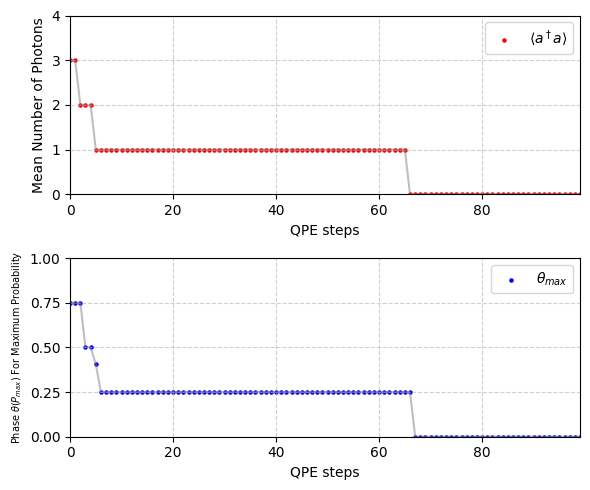

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5))

# Plot do número médio de fótons
time = np.arange(len(mean_photons))

axs[0].plot(mean_photons, color='gray', alpha=0.5)
axs[0].scatter(time, mean_photons, label=r"$\langle a^\dagger a \rangle$", color='red', s=5)
#axs[0].set_xlabel("Time")
axs[0].set_xlabel("QPE steps")
axs[0].set_ylabel("Mean Number of Photons")
axs[0].set_xlim(0, total_time - 1)
#axs[0].set_xlim(0, 15)
axs[0].set_ylim(0, N_max)
axs[0].legend()
#axs[0].set_xticks(np.arange(0, total_time, 5))  
axs[0].grid(True, linestyle='--', alpha=0.6)

# Determinando o θ correspondente à maior probabilidade para cada instante de tempo
#phases = [y / N_max for y in range(0, 2**num_qubits)]  # Valores de θ
theta_max_values = []

phases = [y / 2**num_qubits for y in range(0, 2**num_qubits)]

for prob_list in prob_time_list:
    max_index = np.argmax(prob_list)            # Índice da maior probabilidade
    theta_max_values.append(phases[max_index])  # Adiciona o θ correspondente

# Probabilidade de theta
time = np.arange(len(theta_max_values))

axs[1].plot(theta_max_values, color='gray', alpha=0.5)
axs[1].scatter(time, theta_max_values, label=r"$\theta_{max}$", color='blue', s=5)

#selected_states = [r'$\ket{00000}$', r'$\ket{01000}$', r'$\ket{10000}$', r'$\ket{11000}$', r'$\ket{11111}$'] 
selected_phases = [0, 0.25, 0.5, 0.75, 1.0]
selected_labels = [f"{theta:.2f}" for theta in selected_phases]
axs[1].set_yticks(selected_phases)
axs[1].set_yticklabels(selected_labels)

#axs[1].set_xlabel("Time")
axs[1].set_xlabel("QPE steps")
axs[1].set_ylabel(r"Phase $\theta(P_{max})$ For Maximum Probability", fontsize=7)
axs[1].set_ylim(0, 1.0)
axs[1].set_xlim(0, total_time - 1)
#axs[1].set_xlim(0, 15)#axs[1].set_xticks(np.arange(0, total_time, 5)) 
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend()

plt.tight_layout()
plt.show()

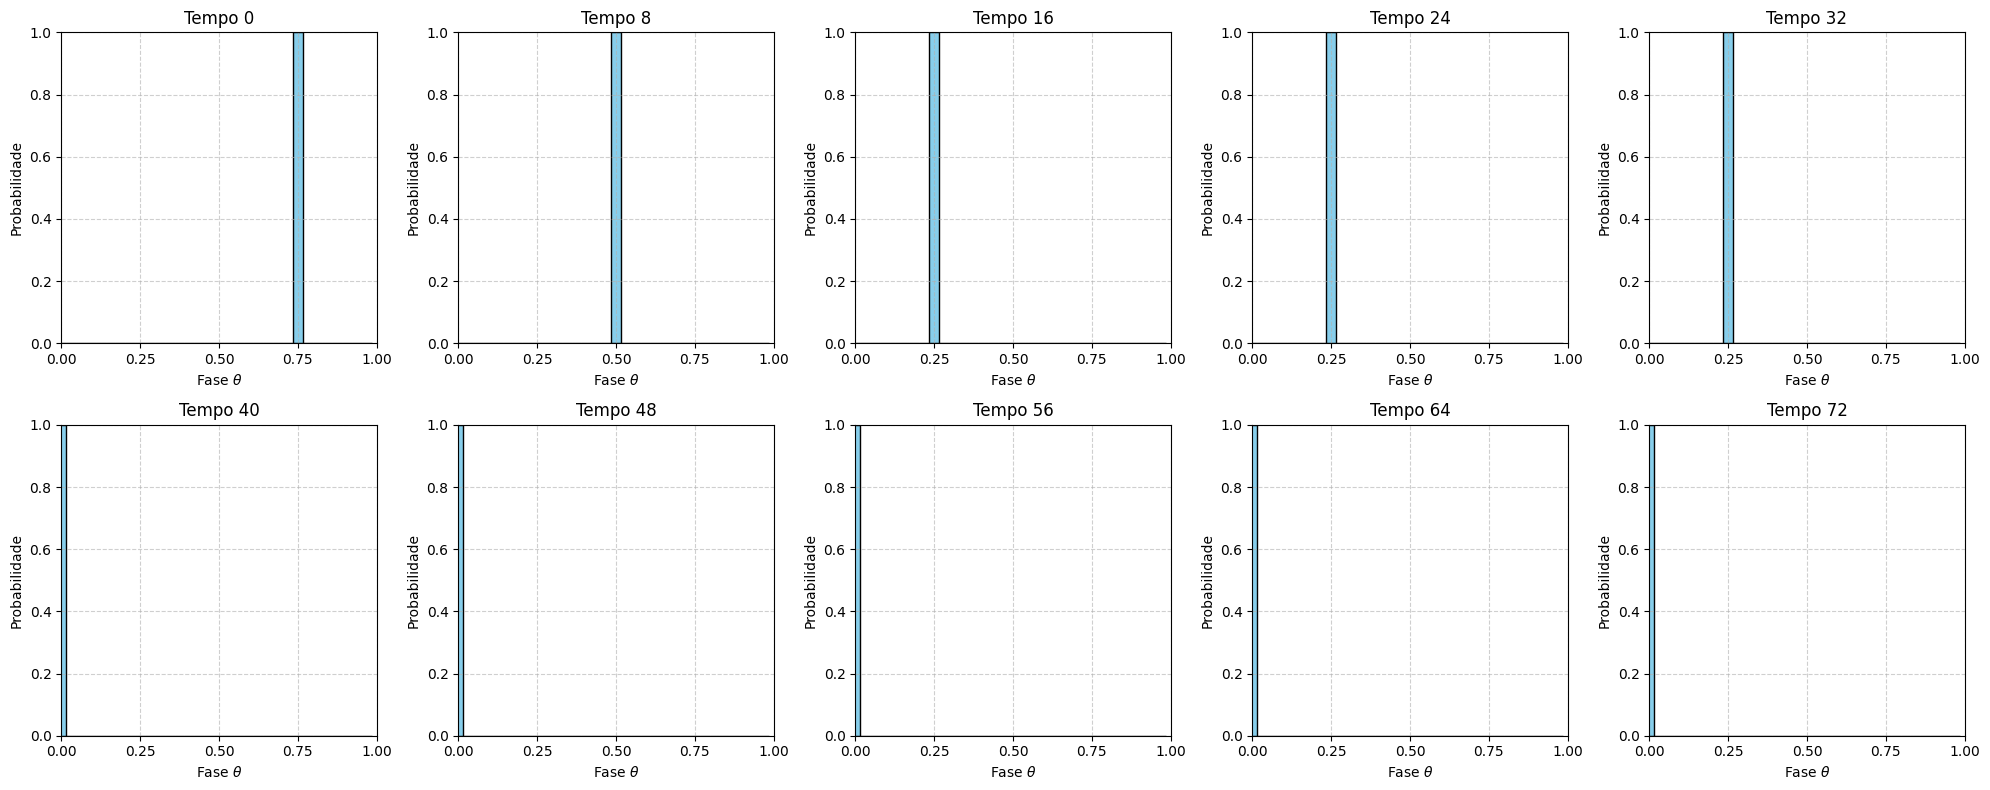

In [12]:
# Probabilidades nos instantes iniciais para o CAMPO QUÂNTICO

fig, axes = plt.subplots(2, 5, figsize=(20, 8))  
axes = axes.flatten()

# Recalcular as fases (0 <= theta < 1) para cada estado da base
phases = [y / 2**num_qubits for y in range(0, 2**num_qubits)]
states = [f"|{bin(y)[2:].zfill(num_qubits)}⟩" for y in range(0, 2**num_qubits)]  

# Fases selecionadas para os rótulos do eixo x
selected_phases = [0, 0.25, 0.5, 0.75, 1.0]
selected_labels = [f"{theta:.2f}" for theta in selected_phases]

# Criar os subplots para 10 instantes ao longo do tempo total
selected_times = list(range(0, 80, 8))  
prob_time = [prob_time_list[t] for t in selected_times]

for t, prob_list in enumerate(prob_time):
    ax = axes[t]
    
    # Plotar as probabilidades para o instante t
    ax.bar(phases, prob_list, width=(1 / 2**num_qubits), align='center', color='skyblue', edgecolor='black')

    # Configuração do eixo
    ax.set_xlabel(r"Fase $\theta$")
    ax.set_ylabel("Probabilidade")
    ax.set_title(f"Tempo {8 * t}")

    # Exibir apenas os rótulos selecionados no eixo x
    ax.set_xticks(selected_phases)
    ax.set_xticklabels(selected_labels)

    # Ajustar grade e limites
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)

# Ajustar layout
fig.tight_layout()
plt.show()